# Parameter Constraints with `halomod`

In this tutorial, parameters of a minimal galaxy HOD are fitted against power spectrum created using `halomod` with some error bars

For auto-power spectrum, all parameters and related calculation can be done using `TracerHaloModel`. Parameters can be easily updated through `update`, which makes it very easy to combine with data fitting tools. Here we use `emcee` as an example.

Let's import those (and a few other things we'll need):

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from halomod import TracerHaloModel
import halomod
import hmf
import emcee
import scipy
from multiprocessing import Pool
import corner

In [2]:
print("halomod version: ", halomod.__version__)
print("hmf version:", hmf.__version__)

halomod version:  1.4.6.dev71+gaca1ec0
hmf version: 3.1.0


## Setting up `TracerHaloModel`

As a simplistic example, we'll be using a Zehavi05 model which is simply:

$$
\big\langle N_{\rm cen}(m) \big\rangle = 1,\; {\rm for}\; m \ge M_{\rm min}
$$
$$
\big\langle N_{\rm cen}(m) \big\rangle = 0,\; {\rm for}\; m < M_{\rm min}
$$

$$
\big\langle N_{\rm sat}(m) \big\rangle = \big(\frac{m}{M_1}\big)^\alpha
$$

which can be specified by `hod_model` and `hod_params` arguments:

In [3]:
hm_fid = TracerHaloModel(hod_model='Zehavi05',hod_params=dict(
{"M_min": 11.6222, "M_1": 12.851, "alpha": 1.049}
))
hm = TracerHaloModel(hod_model='Zehavi05',hod_params=dict(
{"M_min": 11.6222, "M_1": 12.851, "alpha": 1.049}
))

And we've set up our HOD. You can easily update the parameter values:

In [4]:
hm.update(hod_params=dict(
{"M_min": 11.6222, "M_1": 12.851, "alpha": 1.149}))

Compare it with the fiducial power spectrum to check the update:

/home/ztchen/work/gitproject/halomod/src/halomod/tools.py:534: RuntimeWarning: divide by zero encountered in true_divide
  norm = self._spl(match_x) / fnc(match_x)
/home/ztchen/work/gitproject/halomod/src/halomod/tools.py:534: RuntimeWarning: divide by zero encountered in true_divide
  norm = self._spl(match_x) / fnc(match_x)


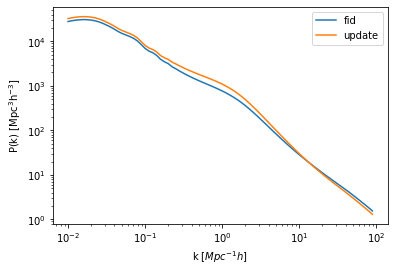

In [5]:
plt.plot(hm_fid.k_hm, hm_fid.power_auto_tracer,label='fid')
plt.plot(hm.k_hm, hm.power_auto_tracer,label='update')
plt.xscale('log')
plt.yscale('log')

plt.xlabel("k [$Mpc^{-1} h$]")
plt.ylabel(r"$\rm P(k) \ [{\rm Mpc^3}h^{-3}]$")
plt.legend(loc="upper right");

Just like that, we're all set.

## MCMC-Fitting

For a naive first-look, let's create some fake error bar:

In [6]:
pkerr = np.linspace(0.01,0.5,num=80)*hm_fid.power_auto_tracer

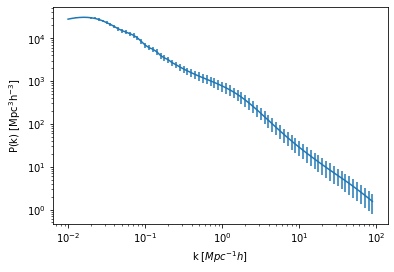

In [7]:
plt.errorbar(hm_fid.k_hm, hm_fid.power_auto_tracer,yerr= pkerr)

plt.xscale('log')
plt.yscale('log')

plt.xlabel("k [$Mpc^{-1} h$]")
plt.ylabel(r"$\rm P(k) \ [{\rm Mpc^3}h^{-3}]$");

And construct a simple Gaussian likelihood function with flat prior:

In [8]:
def autopower(theta,k):
    hm.update(hod_params=theta)
    pk=scipy.interpolate.interp1d(hm.k_hm,hm.power_auto_tracer)
    return pk(k)
def lnprior_flat(params):
    if params[0]>9.00 and params[0]<13.00 and params[1]<16.00 and params[1]>9.00 \
    and params[2]<4 and params[2]>0:
        return 0.0
    else:
        return -np.inf
def log_likelihood_flat(params, x,y,yerr):
    theta=dict({"M_min": params[0], "M_1": params[1], "alpha": params[2]})
    yfit= autopower(theta,x)
    lp = lnprior_flat(params)
    return lp - 0.5 * np.sum(((y-yfit)/yerr)**2)

Test against the fiducial values:

In [9]:
pars = [11.6222, 12.851, 1.049]
print(log_likelihood_flat(pars,hm_fid.k_hm,hm_fid.power_auto_tracer,pkerr))

0.0


/home/ztchen/work/gitproject/halomod/src/halomod/tools.py:534: RuntimeWarning: divide by zero encountered in true_divide
  norm = self._spl(match_x) / fnc(match_x)


Just for a taste of it, let's run the mcmc with 100 walkers and 1000 steps:

In [10]:
pars= np.array([11.6222, 12.851, 1.049])

ndim,nwalkers = 3,100
pos = [pars+1e-2*np.random.uniform(0,1,ndim)*pars for i in range(nwalkers)]
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_flat, \
            args=(hm_fid.k_hm,hm_fid.power_auto_tracer,pkerr),pool=pool)
    #start = time.time()
    sampler.run_mcmc(pos, 1000, progress=True)
    #end = time.time()
    #multi_time = end - start
    #print("Multiprocessing took {0:.1f} seconds".format(multi_time))

100%|██████████| 1000/1000 [20:45<00:00,  1.25s/it]


Getting the chains and extracting posterior:

In [11]:
samples = sampler.get_chain().reshape((-1,3))

In [17]:
mmin,m1,alpha = map(lambda v: (v[1],v[2]-v[1],v[1]-v[0]),\
                    zip(*np.percentile((samples),[16,50,84],axis=0)))

The 1-d confidence interval:

In [18]:
print(mmin)
print(m1)
print(alpha)

(11.569923415144125, 0.20428071115065016, 0.22297037607466308)

And the posterior distribution as a corner plot:

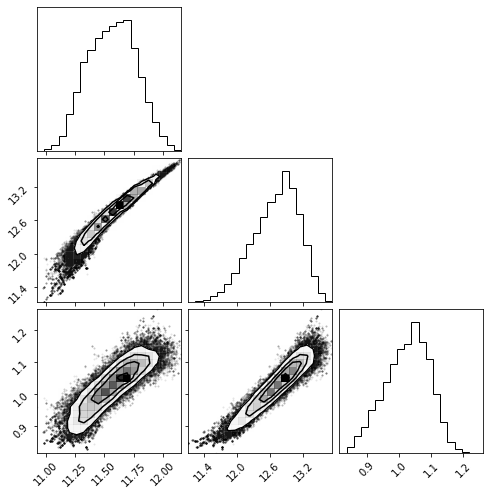

In [25]:
fig = corner.corner(samples);

## Constraining derived parameters

Notice that `halomod` provides a large pool of tools to calculate various quantities of potential interest, making it easier to perform posterior analysis on some parameters derived from your choice of halo model. For example, let's rewrite the likelihood function to add a `blob` containing galaxy number density(`mean_tracer_den`) and linear galaxy bias(`bias_effective_tracer`):

In [8]:
def autopower(theta,k):
    hm.update(hod_params=theta)
    pk=scipy.interpolate.interp1d(hm.k_hm,hm.power_auto_tracer)
    return pk(k), np.array([hm.mean_tracer_den,hm.bias_effective_tracer])
def lnprior_flat(params):
    if params[0]>9.00 and params[0]<13.00 and params[1]<16.00 and params[1]>9.00 \
    and params[2]<4 and params[2]>0:
        return 0.0
    else:
        return -np.inf
def log_likelihood_flat(params, x,y,yerr):
    theta=dict({"M_min": params[0], "M_1": params[1], "alpha": params[2]})
    yfit, arr= autopower(theta,x)
    lp = lnprior_flat(params)
    return lp - 0.5 * np.sum(((y-yfit)/yerr)**2),arr

Now the likelihood function also returns the blob:

In [9]:
pars = [11.6222, 12.851, 1.049]
print(log_likelihood_flat(pars,hm_fid.k_hm,hm_fid.power_auto_tracer,pkerr))

(0.0, array([0.01495764, 1.11274361]))


/home/ztchen/work/gitproject/halomod/src/halomod/tools.py:534: RuntimeWarning: divide by zero encountered in true_divide
  norm = self._spl(match_x) / fnc(match_x)


Rerun the same fitting:

In [10]:
pars= np.array([11.6222, 12.851, 1.049])

ndim,nwalkers = 3,100
pos = [pars+1e-2*np.random.uniform(0,1,ndim)*pars for i in range(nwalkers)]
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_flat, \
            args=(hm_fid.k_hm,hm_fid.power_auto_tracer,pkerr),pool=pool)
    #start = time.time()
    sampler.run_mcmc(pos, 1000, progress=True)
    #end = time.time()
    #multi_time = end - start
    #print("Multiprocessing took {0:.1f} seconds".format(multi_time))

100%|██████████| 1000/1000 [20:52<00:00,  1.25s/it]


Extracting the blob:

In [12]:
blob = sampler.get_blobs().reshape((-1,2))

In [13]:
ng,b0 = map(lambda v: (v[1],v[2]-v[1],v[1]-v[0]),\
                    zip(*np.percentile((blob),[16,50,84],axis=0)))

The 1$\sigma$ confidence interval is:

In [14]:
print(ng)
print(b0)

(0.01652902170349346, 0.018470496973996536, 0.006735292723657369)
(1.112664171509334, 0.0038656722599357263, 0.003738854055712615)
